# Causal discovery with Census data

## Import libraries

In [1]:
import pickle
import pandas as pd
import cdt

import networkx as nx
import matplotlib.pyplot as plt

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


## Load data

In [2]:
try:
    print(f"[INFO] Using pandas version: {pd.__version__}")
    with open("data/df_causal_discovery.p", "rb") as f:
        df = pickle.load(f)
except:
    print("[INFO] Downgrading pandas to 1.5 to load the data...")
    !conda install -q -y pandas=1.5
    with open("data/df_causal_discovery.p", "rb") as f:
        df = pickle.load(f)

df.head()

[INFO] Using pandas version: 1.5.3


,age,hours-per-week,hasGraduateDegree,inRelationship,isWhite,isFemale,greaterThan50k
0,39,40,0,0,1,0,0
1,50,13,0,1,1,0,0
2,38,40,0,0,1,0,0
3,53,40,0,1,0,0,0
5,37,40,1,0,1,1,0


## Create skeleton graph using graph Lasso

A (graph) skeleton is an undirected graph where every edge corresponds to a pair of variables that are statistically dependent. For a lot of these causal discovery algorithms, it helps to start off with a graph skeleton. We can do it with `cdt.independence.graph.Glasso()`.

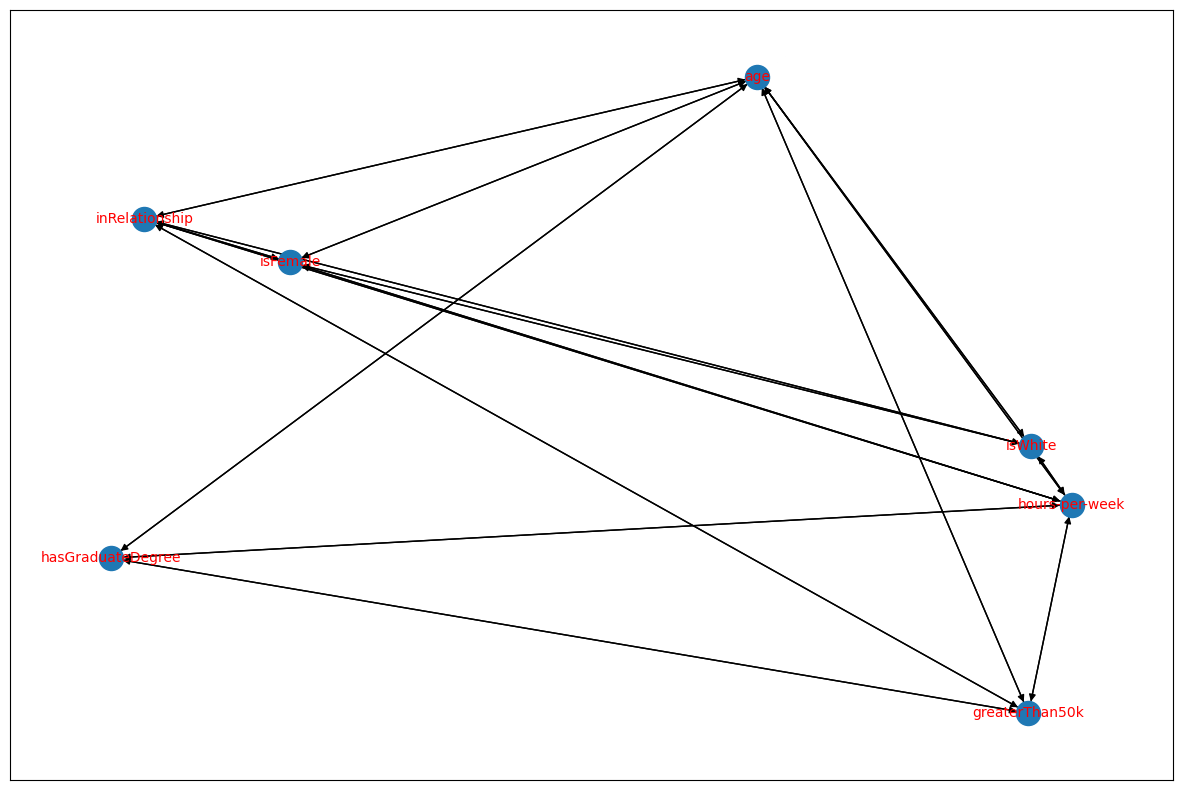

In [5]:
# Initialise graph lasso
glasso = cdt.independence.graph.Glasso()

# Apply graph lasso to the dataset
skeleton = glasso.predict(df)

# Create layout with fixed seed
pos = nx.spring_layout(skeleton, seed=42)

# Remove self-loops
skeleton.remove_edges_from(nx.selfloop_edges(skeleton))

# Plot the graph
fig = plt.figure(figsize=(15, 10))
nx.draw_networkx(skeleton,
                 pos=pos,
                 font_size=10, 
                 font_color='r')

## Use Causal discovery algorithms to get a causal model

We're going to implement 3 causality discovery algorihtms with `cdt.causality.graph`:
1. PC
2. GES
3. LiNGAM 

### 1. PC

**Note:** `cdt.causality.graph.PC()` requires the following R libraries installed in your virtual environment (or system) to run:
- `pcalg`: Can be installed with `conda install -c conda-forge r-pcalg`. Some of its dependencies might require `Bioconductor` to be installed.
- `kpcalg`: Can be installed with `setup_kpcalg.r` in this repo.
- `RCIT`: First install `devtools`, then install `RCIT` with `devtools` from its github repo.

After installation, you can try this on your terminal:
`Rscript -e "library(pcalg);library(kpcalg);library(RCIT);print('All requirements fulfilled')"`

PC is ran on the skeleton of the given graph.


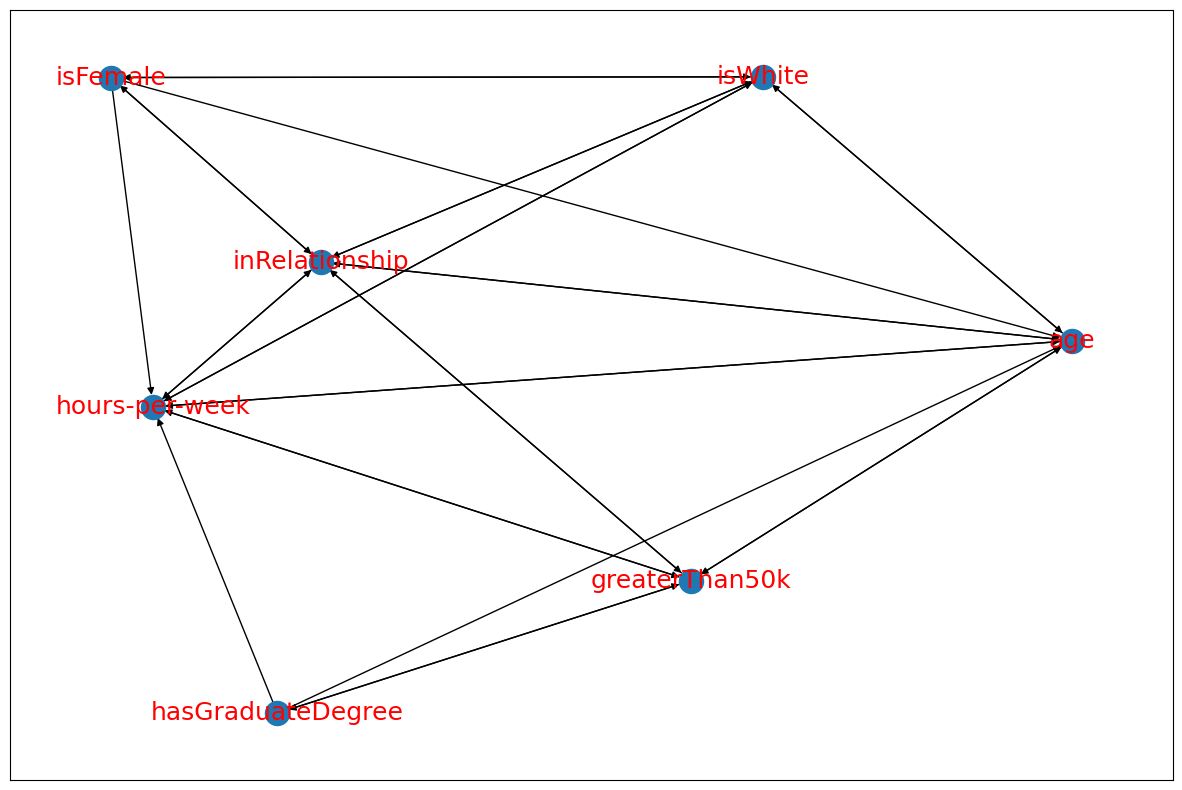

In [6]:
# Initialise a pc model
model_pc = cdt.causality.graph.PC()

# Predict on the dataset and the skeleton
graph_pc = model_pc.predict(df, skeleton)

# Create a layout with fixed seed
pos = nx.spring_layout(graph_pc, seed=42)

# Plot the graph
fig = plt.figure(figsize=(15, 10))
nx.draw_networkx(graph_pc,
                 pos=pos,
                 font_size=18,
                 font_color='r')

In [15]:
# Get the adjacency matrix of the PC graph
adjacency_matrix_pc = nx.adjacency_matrix(graph_pc).todense() # todense() converts a crs matrix (sparse matrix) to a dense numpy matrix
adjacency_matrix_pc

array([[0, 1, 0, 1, 1, 0, 1],
       [1, 0, 1, 1, 1, 0, 0],
       [1, 1, 0, 1, 0, 0, 0],
       [1, 1, 0, 0, 1, 0, 1],
       [1, 1, 0, 1, 0, 1, 1],
       [1, 0, 0, 1, 1, 0, 1],
       [1, 0, 0, 1, 1, 1, 0]])

In [18]:
# Get the nodes order
nodes_order = list(graph_pc.nodes())

# Convert the matrix to DataFrame
adjacency_df_pc = pd.DataFrame(adjacency_matrix_pc,
                               columns=nodes_order,
                               index=nodes_order)
adjacency_df_pc

,age,greaterThan50k,hasGraduateDegree,hours-per-week,inRelationship,isFemale,isWhite
age,0,1,0,1,1,0,1
greaterThan50k,1,0,1,1,1,0,0
hasGraduateDegree,1,1,0,1,0,0,0
hours-per-week,1,1,0,0,1,0,1
inRelationship,1,1,0,1,0,1,1
isFemale,1,0,0,1,1,0,1
isWhite,1,0,0,1,1,1,0


Let's evaluate some of the causal relationships found by the PC algorithm:
- `isFemale` -> `hours-per-week` (makes sense)
- `hasGraduateDegree` -> `hours-per-week` (makes sense)
- `hasGraduateDegree` -> `age` (doesn't make sense; should be the other way round).

### 2. GES

GES is ran on the skeleton of the given graph.


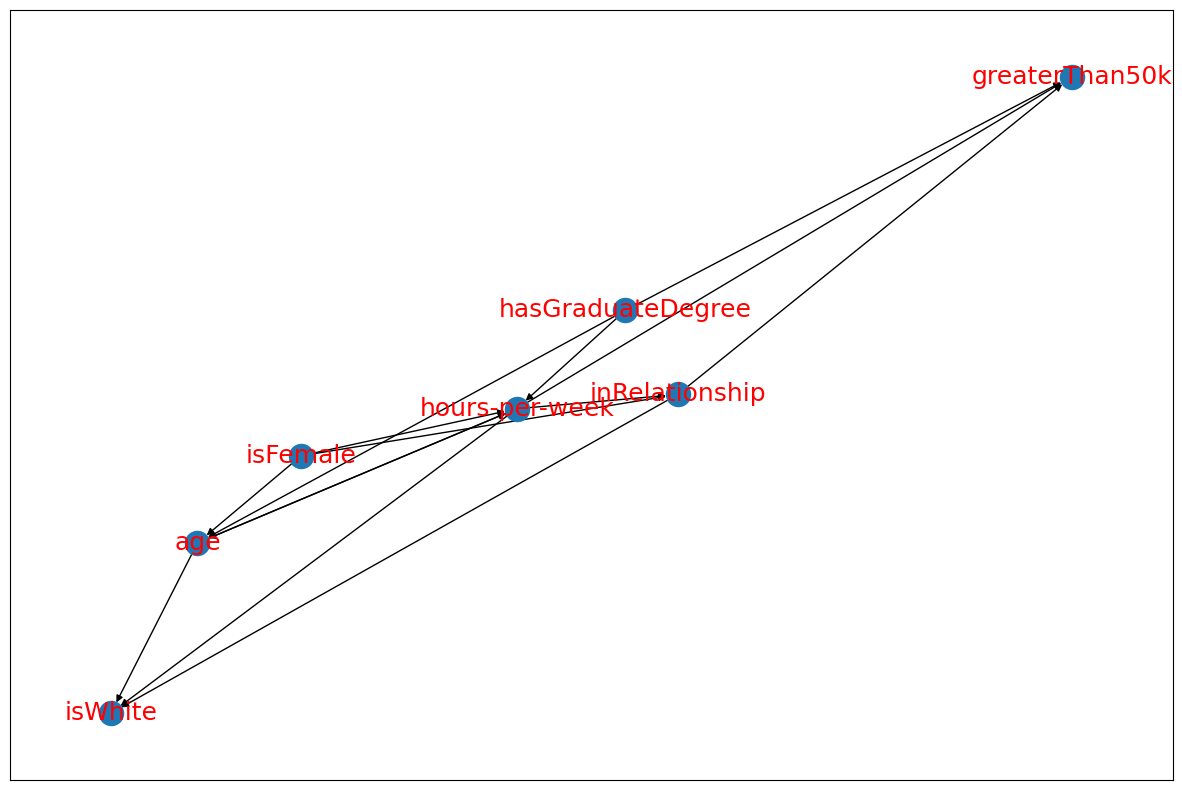

In [19]:
# Initialise a GES model
model_ges = cdt.causality.graph.GES()

# Predict on the dataset and the skeleton
graph_ges = model_ges.predict(df, skeleton)

# Create a layout with fixed seed
pos = nx.spring_layout(graph_ges, seed=42)

# Plot the graph
fig = plt.figure(figsize=(15, 10))
nx.draw_networkx(graph_ges,
                 pos=pos,
                 font_size=18,
                 font_color='r')

In [20]:
# Get the adjacency matrix of the GES graph
adjacency_matrix_ges = nx.adjacency_matrix(graph_ges).todense() # todense() converts a crs matrix (sparse matrix) to a dense numpy matrix

# Convert the matrix to DataFrame
adjacency_df_ges = pd.DataFrame(adjacency_matrix_ges,
                               columns=nodes_order,
                               index=nodes_order)
adjacency_df_ges

,age,greaterThan50k,hasGraduateDegree,hours-per-week,inRelationship,isFemale,isWhite
age,0,0,0,1,0,0,1
greaterThan50k,0,0,0,0,0,0,0
hasGraduateDegree,1,1,0,1,0,0,0
hours-per-week,1,1,0,0,1,0,1
inRelationship,0,1,0,0,0,0,1
isFemale,1,0,0,1,1,0,0
isWhite,0,0,0,0,0,0,0


GES seems to be more informative than PC because it breaks more symmetries (undetermined causal effects) than in PC. For example:
- `isFemale` -> `inRelationship`
- `hours-per-week` -> `greaterThan50k`.

As in PC, some of the causal relationship found don't make sense, for example:
- `age` -> `isWhite`.

### 3. LiNGAM

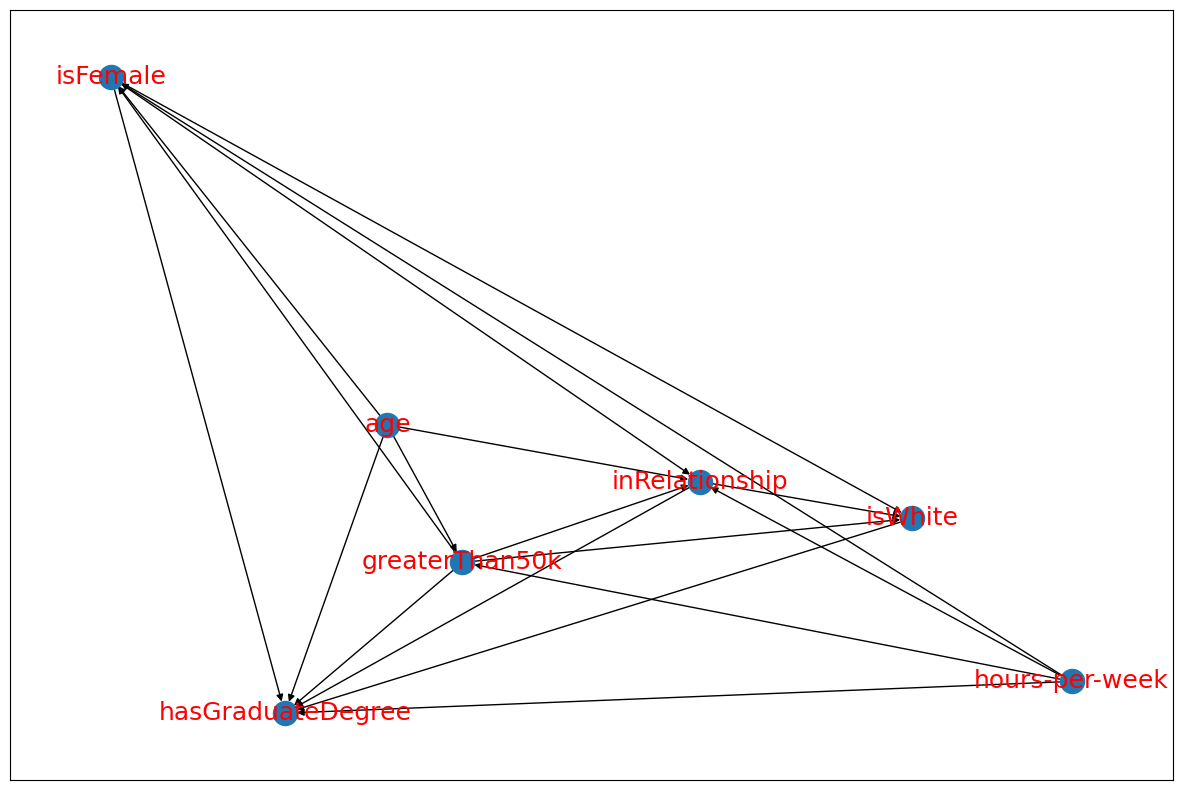

In [21]:
# Initialise a LiNGAM model
model_lingam = cdt.causality.graph.LiNGAM()

# Predict on the dataset
graph_lingam = model_lingam.predict(df) # LiNGAM doesn't need a skeleton

# Create a layout with fixed seed
pos = nx.spring_layout(graph_lingam, seed=42)

# Plot the graph
fig = plt.figure(figsize=(15, 10))
nx.draw_networkx(graph_lingam,
                 pos=pos,
                 font_size=18,
                 font_color='r')

In [22]:
# Get the adjacency matrix of the LiNGAM graph
adjacency_matrix_lingam = nx.adjacency_matrix(graph_lingam).todense() # todense() converts a crs matrix (sparse matrix) to a dense numpy matrix

# Convert the matrix to DataFrame
adjacency_df_lingam = pd.DataFrame(adjacency_matrix_lingam,
                               columns=nodes_order,
                               index=nodes_order)
adjacency_df_lingam

,age,greaterThan50k,hasGraduateDegree,hours-per-week,inRelationship,isFemale,isWhite
age,0.0,0.0,3.926433,9.821336,0.000000,3.745299,3.648796
greaterThan50k,0.0,0.0,2.127265,2.684981,0.000000,-3.621554,4.352480
hasGraduateDegree,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
hours-per-week,0.0,0.0,0.093248,0.000000,0.201129,0.000000,0.000000
inRelationship,0.0,0.0,0.062013,0.000000,0.000000,0.000000,0.000000
isFemale,0.0,0.0,0.052879,-0.554915,-0.060266,0.000000,0.000000
isWhite,0.0,0.0,0.298840,0.356124,0.052093,0.019324,0.000000


In contrast to PC and GES, where their adjacency matrices are binary, LiNGAM's contain float values that represent the strength of the causal effects.
LiNGAM found some causal relationships that the other two couldn't, for example:
- `age` -> `hours-per-week` (strong causal effect indicated by 9.821)
- `age` -> `hasGraduateDegree`.

However, as in the other two algorithms, some of them don't make sense:
- `greaterThan50k` -> `isWhite` (medium causal effect indicated by 4.35).